In [51]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.fft as fft
import seaborn as sns
sns.set()

from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from tqdm.notebook import tqdm

import sys
sys.path.append("/home/evangelos/workspace/Channel_Charting/")
from tools import utils
from src.models import supervised_classifier, supervised_regressor
from src.utils.data_preparation import SupervisedDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# load datasets
(raw_taps, raw_phi, raw_theta, raw_rx_positions, raw_tx_positions) = utils.load_datasets()

In [3]:
#fourier transform and undersample taps
raw_freq_taps = fft.fft(raw_taps , workers=-1)[:,:,::2]

In [4]:
def preprocessing(data, first_data, rx_positions, padding=True):
    data = utils.drop_top_right(data, rx_positions)
    data = utils.standarize(data)
    data = utils.fillna(data)
    if padding:
        data = utils.zero_padding_as(data, first_data)
    #data = utils.take_norm(data)
    
    return data

In [5]:
taps = preprocessing(raw_freq_taps, raw_freq_taps, raw_rx_positions)
taps = np.hstack([np.real(taps), np.imag(taps)])

In [6]:
phi = preprocessing(raw_phi, taps, raw_rx_positions)

In [7]:
theta = preprocessing(raw_theta, taps, raw_rx_positions)

In [8]:
y  = preprocessing(raw_rx_positions, taps, raw_rx_positions, padding=False)[:,:2]

In [9]:
X = np.hstack([taps, phi[:-10], theta[:-10]])

In [12]:
#assign labels to certain areas of the map using kmeans
from sklearn.cluster import KMeans
km = KMeans(n_clusters=8) 
km = km.fit(y)
labels = km.predict(y)

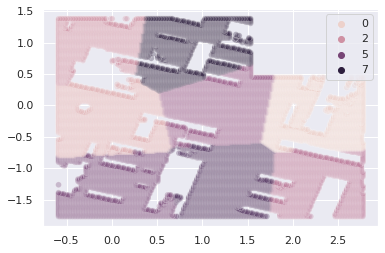

In [13]:
sns.scatterplot(y[:,0], y[:,1], hue=labels, alpha=0.3)

In [14]:
#train test split
train_X, test_X ,train_y, test_y, train_labels, test_labels = train_test_split(X, y, labels)
train_DS = SupervisedDataset(train_X, train_labels)
test_DS = SupervisedDataset(test_X, test_labels)

In [15]:
train_loader = DataLoader(train_DS, batch_size=32)
test_loader = DataLoader(test_DS)

In [45]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")

model = supervised_classifier.Classifier(channels=train_DS.channels(), nb_labels=8)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [46]:
best_val_loss = 9999
count = 0
for epoch in tqdm(range(100)):
    loss = supervised_classifier.train(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = supervised_classifier.test(model, test_loader, criterion, device)
    print(f"Epoch {epoch+1}: Training Loss {loss}, Validation Loss {val_loss}, Validation Accuracy {val_acc}")
    
    if best_val_loss < val_loss:
        count += 1
    else:
        best_val_loss = val_loss
    if count > 5:
        break

Epoch 1: Training Loss 0.046104932074536906, Validation Loss 1.1863286905644095, Validation Accuracy 0.5469310670443815
Epoch 2: Training Loss 0.036314394235655995, Validation Loss 1.0588614011634339, Validation Accuracy 0.6196411709159585
Epoch 3: Training Loss 0.032402395410260916, Validation Loss 1.0785468830125335, Validation Accuracy 0.6060434372049103
Epoch 4: Training Loss 0.03026785156006763, Validation Loss 0.9559840509775736, Validation Accuracy 0.6553352219074599
Epoch 5: Training Loss 0.027847932129657398, Validation Loss 0.9097533815686014, Validation Accuracy 0.6725212464589235
Epoch 6: Training Loss 0.026233196204130307, Validation Loss 0.8875383471516577, Validation Accuracy 0.6715769593956563
Epoch 7: Training Loss 0.0248531364549477, Validation Loss 0.8179051621410478, Validation Accuracy 0.7102927289896128
Epoch 8: Training Loss 0.023912204381073558, Validation Loss 0.8173502241407127, Validation Accuracy 0.7046270066100094
Epoch 9: Training Loss 0.0222171334378449, 

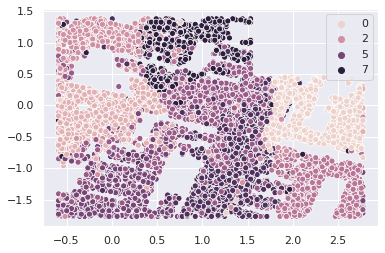

In [59]:
yhats = model(test_DS[:][0]).detach()
predictions = yhats.argmax(dim=1)
plot = sns.scatterplot(test_y[:,0], test_y[:,1], hue=predictions)

In [60]:
plot

In [48]:
print(classification_report(predictions, test_labels))

              precision    recall  f1-score   support

           0       0.91      0.94      0.92       604
           1       0.81      0.90      0.85       770
           2       0.78      0.72      0.75       434
           3       0.88      0.95      0.91       521
           4       0.66      0.54      0.59      1000
           5       0.69      0.79      0.74       581
           6       0.76      0.67      0.71       882
           7       0.76      0.89      0.82       503

    accuracy                           0.77      5295
   macro avg       0.78      0.80      0.79      5295
weighted avg       0.77      0.77      0.77      5295



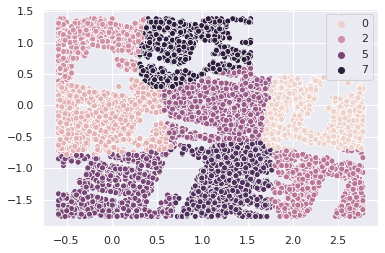

In [49]:
sns.scatterplot(test_y[:,0], test_y[:,1], hue=test_labels)

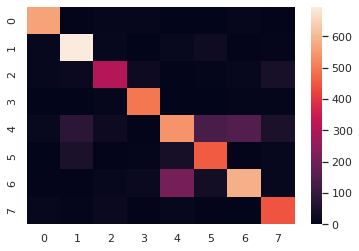

In [50]:
sns.heatmap(confusion_matrix(predictions, test_labels))

In [53]:
accuracy_score(predictions, test_labels)

0.7741265344664778

In [56]:
report = classification_report(predictions, test_labels, output_dict=True)

In [57]:
report

{'0': {'precision': 0.907051282051282,
  'recall': 0.9370860927152318,
  'f1-score': 0.9218241042345278,
  'support': 604},
 '1': {'precision': 0.8051044083526682,
  'recall': 0.9012987012987013,
  'f1-score': 0.8504901960784313,
  'support': 770},
 '2': {'precision': 0.7775,
  'recall': 0.716589861751152,
  'f1-score': 0.7458033573141486,
  'support': 434},
 '3': {'precision': 0.8780918727915195,
  'recall': 0.9539347408829175,
  'f1-score': 0.9144434222631095,
  'support': 521},
 '4': {'precision': 0.6577344701583435,
  'recall': 0.54,
  'f1-score': 0.5930807248764416,
  'support': 1000},
 '5': {'precision': 0.6903323262839879,
  'recall': 0.7865748709122203,
  'f1-score': 0.7353177795655671,
  'support': 581},
 '6': {'precision': 0.7577319587628866,
  'recall': 0.6666666666666666,
  'f1-score': 0.7092882991556092,
  'support': 882},
 '7': {'precision': 0.7636986301369864,
  'recall': 0.8866799204771372,
  'f1-score': 0.8206071757129715,
  'support': 503},
 'accuracy': 0.774126534466